In [1]:
# v1.3 ARIMA 시계열 분석 모형으로 예측하기. (하루단위로 보기)
# v1.2 수수료 기반 백테스팅 작업, AI 이용한 upper, lower 예측(분류모델 + gridcv로 최적 파라미터 설정), 코드 정리 
# v1.1 확대 축소가 아닌 Low, Upper에 닿을 경우 매수, 매도 결정, 5일 이동평균선 기준
# v1.0 볼린저 밴드 (확대, 축소)를 이용한 알고리즘 매수, 매도 결정

import pandas as pd
import numpy as np
import pyupbit
import datetime
import time
import os

# # min_key numbers
# access_key='WNlqEotmOTIxYKvgtrQupedaI1g0E4n8ultRrTMeUxAa' # key encrypt
# secret_key='91I4c67FhA88yRLTCuYp7D3N3p1h6Tc0jOEVd0x302R1' # key encrypt

# jiwoo numbers
access_key='RxxAtjdh5TCBv4Wc9ycWKILVBsDhE31Z0e4i8JVXadxF' # key encrypt
secret_key='xavsrBGokR5fqeivyA4ctxFrJgM3f3j1b6CCJmxRY5I5' # key encrypt

upbit=pyupbit.Upbit(access_key,secret_key) # upbit 함수 이용하기

# 초기 데이터 추천
def start_settings(tickers):
    # 1시간 데이터 확보
    time2=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:00')
    data = pyupbit.get_ohlcv(tickers, interval="minute1", count=60, to=time2) # 60분 추출
    i=1
    while(i<2): # 데이터 수 확장하기  (1시간 데이터 추출)
            date = data.index[0]
            data2 = pyupbit.get_ohlcv(tickers, interval="minute1", count=30, to=date)
            data = pd.concat([data,data2], axis=0)  
            data = data.sort_index()
            i+=1
            time.sleep(1)
    return data

# Data 확보
def settings(tickers):
    # 24시간 데이터 확보
    time2=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:00')
    data = pyupbit.get_ohlcv(tickers, interval="minute1", count=5, to=time2)  # 120분 추출
    i=1
    while(i<73): # 데이터 수 확장하기  (24시간 데이터 추출) # 3일치
            date = data.index[0]
            data2 = pyupbit.get_ohlcv(tickers, interval="minute3", count=5, to=date)
            data = pd.concat([data,data2], axis=0)  
            data = data.sort_index()
            i+=1
            time.sleep(1)
    return data

# 볼린저밴드 만들기(upper, middle, lower)
def BAND_data(df):
    
    #종가를 이용
    df['line_5']=df['open'].rolling(window=5).mean() # 5일 이동평균선
    df['line_10']=df['open'].rolling(window=10).mean() # 10일 이동평균선
    df['band_mid']=df['open'].rolling(window=20).mean() # 20일 이동평균선
    df['band_up']=df['band_mid']+(df['open'].rolling(window=20).std()*2)  # upper
    df['band_low']=df['band_mid']-(df['open'].rolling(window=20).std()*2)  # lower
    df=df.fillna(0) # 없는 데이터 채우기
    return df

#양봉, 음봉 캔들 생성
def minute_1(temp_df, i):
    blue_b_price=0
    blue_t_price=0
    blue=0
    red_b_price=0
    red_t_price=0
    red=0
    # 일봉 매수, 매도 점 위치 파악 (빨간색, 파란색인지 구별) -> 가격 변수 설정
    chai= (np.round(temp_df.loc[temp_df.index[i],'open'],0) - np.round(temp_df.loc[temp_df.index[i],'close'],0)).astype('float')
    if chai >= 0.0: # 음봉
        blue_b_price=np.round(temp_df.loc[temp_df.index[i],'close'],0)
        blue_t_price=np.round(temp_df.loc[temp_df.index[i],'open'],0)
        blue=1
    else: #양봉
        red_b_price=np.round(temp_df.loc[temp_df.index[i],'open'],0)
        red_t_price=np.round(temp_df.loc[temp_df.index[i],'close'],0)   
        red=1
        
    return blue_b_price, blue_t_price, blue, red_b_price, red_t_price, red

# 볼린저 밴드를 이용한 매수 매도 누적 수익률 test 함수
def band_trainig(temp_df):
    temp_df['B/S']=0  # buy=1, sell=-1
    sign=0  # 매수 or 매도 타이밍
    cnt=0 # 매수 개수
    
    for i in range(1,len(temp_df)):
        mid_price=temp_df.loc[temp_df.index[i],'band_mid']
        upper=temp_df.loc[temp_df.index[i],'band_up']
        lower=temp_df.loc[temp_df.index[i],'band_low']
        line_5=temp_df.loc[temp_df.index[i],'line_5']
        blue=0
        red=0
        
        # 일봉 매수, 매도 점 위치 파악 (빨간색, 파란색인지 구별) -> 가격 변수 설정
        blue_b_price, blue_t_price, blue, red_b_price, red_t_price, red = minute_1(temp_df, i)
            
        if blue==1 and upper<blue_t_price and mid_price<blue_t_price:   #블루봉 사인
            sign=-1 # 매도 타이밍 발생
        elif blue==1 and lower>blue_b_price and mid_price>blue_b_price: 
            sign=1 # 매수 타이밍 발생(1)
        elif red==1 and upper<red_t_price and mid_price<red_t_price:    #레드봉 사인
            sign=-1 # 매도 타이밍 발생(-1)
        elif red==1 and lower>red_b_price and mid_price>red_b_price:
            sign=1 # 매수 타이밍 발생
        
        if sign==-1: # 시그널 지속하며 꺾는점 발생 (진정한 매도 타이밍)
            if blue==1 and blue_t_price<line_5 and mid_price<blue_b_price and cnt>0: # 고점형성 기준 블루봉일시 매도
                temp_df.loc[temp_df.index[i],'B/S']=-1   # 매도한다. 
                cnt=0
                sign=0

            elif red==1 and red_t_price<line_5 and mid_price<red_b_price and cnt>0: # 고점형성 기준 레드봉일시 매도
                temp_df.loc[temp_df.index[i],'B/S']=-1   # 매도한다. 
                cnt=0
                sign=0
                
        elif sign==1: # 시그널 지속하며 꺾는점 발생 (진정한 매수 타이밍)
            if red==1 and mid_price>red_b_price and red_b_price>line_5: # 저점형성 기준 레드봉일시 매수 (레드봉일시만 매수!! (핵심))
                temp_df.loc[temp_df.index[i],'B/S']=1   # 매수한다. 
                cnt+=1
                sign=0
    return temp_df

#누적수익률 계산 함수
def test_rate(temp_df):
    price=0
    cnt=0 # 처음 개수
    sell_rate=[] # 기간별 수익률
    cnt_sum=[]
    total_rate=1
    fee=0.0005  # upbit 수수료 고려
    for i in range(1,len(temp_df)):
        # 일봉 매수, 매도 점 위치 파악 (빨간색, 파란색인지 구별) -> 가격 변수 설정
        blue_b_price, blue_t_price, blue, red_b_price, red_t_price, red = minute_1(temp_df, i)
        
        if temp_df.loc[temp_df.index[i],'B/S']==1 and red==1:   # 매수는 시가로 매수한다. (red일시만 매수)
            price=(price+(red_b_price*(1.0+fee))) # red일 시 아랫 부분
            cnt+=1
        elif temp_df.loc[temp_df.index[i],'B/S']==-1 and cnt>0  and (blue==1 or red==1): # 매도
            if blue==1:  # 블루일시 윗 부분
                sell_p=(blue_t_price*cnt*(1.0-fee))
            elif red==1: # 레드일시 윗 부분
                sell_p=(red_t_price*cnt*(1.0-fee))
            rate=np.round(((sell_p-price)/price),4)
            sell_rate.append(rate)
            cnt_sum.append(cnt)
            price=0
            cnt=0
    # 총 누적수익률
    try:
        for rate in sell_rate:
            total_rate*=(1+rate)
        total_rate-=1
        total_rate=np.round(total_rate*100,5)
        if len(cnt_sum)!=0:
            cnt_max=max(cnt_sum)
        else:
            cnt_max=0
    except:
        cnt_max='error'
        total_rate='error'
    return total_rate, cnt_max

def not_trade(tickers, time2): # 미체결된 주문 취소
    ret=upbit.get_order(tickers, state='wait')
    i=0
    while len(ret)!=0:
        ret=upbit.get_order(tickers)
        uuid=ret.pop(0)['uuid']
        ret2=upbit.cancel_order(uuid)
        print('{0} 미체결된 주문 {2} 중 {1}원이 취소되었습니다.'.format(time2,ret2['price'],tickers[4:]))
        i+=1

def buy_trade(tickers, time2, cnt, buy_cnt): #매수 함수
    try:
        ret=upbit.get_balances()
        check=0
        for name in ret:
            if name['currency']==tickers[4:]:  # 잔고에 있는 매수가 확인
                if float(name['avg_buy_price'])>price:
                    check=0
                else:
                    check=1
        price=pyupbit.get_current_price(tickers)
        if check==1:
            print('잔고에 있는 평균가 {0}원이 주문가격 {1}원보다 낮아 매수 주문이 취소되었습니다.'.format(name['avg_buy_price'],price))
        else: 
            ret = upbit.buy_market_order(tickers, price*buy_cnt) # 시장가 매수를 가격으로 한다.
            cnt+=1
            print('{1} 으로 {2}는 {0}원으로 현재 {4}{3}를 매수 주문 완료했습니다.'.format(price,time2,tickers,tickers[4:],buy_cnt)) 
        return cnt, price
    except:
        print(ret)
        return cnt, price

def sell_trade(tickers, time2, cnt, buy_cnt): #매도 함수   
    try:
        ret=upbit.get_balances()
        for name in ret:
            if name['currency']==tickers[4:]:  # 잔고에 있는 매수평균가 서칭
                avg_buy_price=float(name['avg_buy_price'])
                ret = upbit.sell_market_order(tickers, buy_cnt*cnt)
                price=pyupbit.get_current_price(tickers)
                while True:
                    if len(upbit.get_order(tickers, state='wait'))==0:
                        print('{1} 기준으로 {2}는 {0}원으로 주문({3}) 만큼 매도 완료했습니다.'.format(price,time2,tickers[4:],buy_cnt))
                        avg_price=np.round(((price-avg_buy_price)/avg_buy_price*100),2)
                        print('{0} 수익률은 {1}% 입니다.'.format(time2,avg_price))
                        cnt=0
                        break
        return cnt, price
    except:
        print(ret)
        return cnt, price

# 매수 or 매도 프로그램
def trade(tickers, df, buy_cnt, sign, cnt): # sign=매수 or 매도 타이밍 # band_trainig 에서 결정된 signal 값
    
    #최신데이터 band 형성
    df=BAND_data(df)
    line_5=df.loc[df.index[-1],'line_5']
    line_10=df.loc[df.index[-1],'line_5']
    upper=df.loc[df.index[-1],'band_up']
    lower=df.loc[df.index[-1],'band_low']
    df.loc[df.index[-1],'B/S']=0
    blue=0
    red=0
    sell_check=0
    
    # 일봉 매수, 매도 점 위치 파악 (빨간색, 파란색인지 구별) -> 가격 변수 설정
    blue_b_price, blue_t_price, blue, red_b_price, red_t_price, red = minute_1(df, -1)
    
    #변수 설정
    price=pyupbit.get_current_price(tickers)  #현재 가격
    time2=df.index[-1]  #시간
    avg_buy_price=0.0
    avg_price=0.0
    
    #band에 따른 매수 or 매도 결정
    mid_price=df.loc[df.index[-1],'band_mid']
    
    # signal 발생
    if blue==1 and upper<blue_t_price and mid_price<blue_t_price:   #블루봉 사인
        sign=-1 # 매도 타이밍 발생
    elif blue==1 and lower>blue_b_price and mid_price>blue_b_price: 
        sign=1 # 매수 타이밍 발생(1)
    elif red==1 and upper<red_t_price and mid_price<red_t_price:    #레드봉 사인
        sign=-1 # 매도 타이밍 발생(-1)
    elif red==1 and lower>red_b_price and mid_price>red_b_price:
        sign=1 # 매수 타이밍 발생
    
    if sign==-1 and cnt>0: # 시그널 지속하며 꺾는점 발생 (진정한 매도 타이밍)
        if blue==1 and blue_t_price<line_5 and mid_price<blue_b_price: # 고점형성 기준 블루봉일시 매도
            df.loc[df.index[-1],'B/S']=-1   # 매도한다. 
            cnt, price = sell_trade(tickers, time2, cnt, buy_cnt) # 시장가 매도
            sign=0
            sell_check=1

        elif red==1 and red_t_price<line_5 and mid_price<red_b_price: # 고점형성 기준 레드봉일시 매도
            df.loc[df.index[-1],'B/S']=-1   # 매도한다. 
            cnt, price = sell_trade(tickers, time2, cnt, buy_cnt) # 시장가 매도
            sign=0
            sell_check=1
            
        else:
            print('{1} 기준으로 {2}는 {0}원으로 현재 보류중입니다.(signal 보류 중)'.format(price,time2,tickers))

    elif sign==1: # 시그널 지속하며 꺾는점 발생 (진정한 매수 타이밍)
        if red==1 and mid_price>red_b_price and red_b_price>line_5: # 저점형성 기준 레드봉일시 매수 (레드봉일시만 매수!! (핵심))
            df.loc[df.index[-1],'B/S']=1   # 매수한다. 
            cnt, price = buy_trade(tickers, time2, cnt, buy_cnt)  # 시장가 매수
            sign=0
            
        else:
            print('{1} 기준으로 {2}는 {0}원으로 현재 보류중입니다.(signal 보류 중)'.format(price,time2,tickers))
    
    else:
        print('{1} 기준으로 {2}는 {0}원으로 현재 보류중입니다.'.format(price,time2,tickers))
        
    return sign, cnt, df, sell_check
        
# 반복 함수 설정
def repeat_module(tickers, band_df, start_rate, buy_cnt):
    sign=0   # band 발생 표시 여부
    cnt=0    # 중복 매수 여부
    while True:
        try:
            time2=datetime.datetime.now()
            if time2.second==1:
                time2=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:00')
                not_trade(tickers, time2)  # 미체결된 주문 취소
                temp = pyupbit.get_ohlcv(tickers, interval="minute1", count=1, to=time2)
                time.sleep(1)
                band_df=pd.concat([band_df,temp], axis=0)
                band_df.drop([band_df.index[0]], inplace=True)
                sign, cnt, band_df, sell_check=trade(tickers, band_df, buy_cnt, sign, cnt)
                rate, cnt_max = test_rate(band_df)
                #print("개발자 전용: test= {0}%".format(rate))
                if rate<0 and sell_check==1:  # 예상 수익률이 음수이면서 매도한 직후 인경우 수익률 조정
                    print("-----------------Program Pause------------------------")
                    print("   예상수익률 허용범위 벗어나 시스템 재가동 필요      ")
                    print("                                                      ")
                    print("   현재 매수되어 있는 수량: {0}개".format(cnt))
                    print("-----------------Program Pause------------------------")
                    tickers, band_df, start_rate, buy_cnt=slot_setting(0,tickers)

        except KeyboardInterrupt:   # 무한반복 종료
            print("-------------------------Program Pause-------------------------")
            print("       중복 키 입력으로 시스템 중지 및 초기화면 이동           ")
            print("                                                               ")
            print("       현재 매수되어 있는 수량: {0}개".format(cnt))
            print("-------------------------Program Pause-------------------------")
            os.system("pause")
            os.system("cls")
            tickers, band_df, start_rate, buy_cnt=slot_setting(0,tickers)
            
# 초기 실행 시 1시간 수익률이 높은 것 top10 종목 선정
def choose_select(tickers_list):
    dic_rate={}
    for coin in tickers_list:
        data=start_settings(coin)
        data=BAND_data(data)
        data=band_trainig(data)
        temp_rate, cnt_max=test_rate(data)
        dic_rate[coin]=np.round(temp_rate,2)
    df_rate=pd.DataFrame(list(dic_rate.items()), columns=['coin','rate'])
    df_rate=df_rate.sort_values(by='rate', ascending=False).reset_index(drop=True)
    df_rate=df_rate[:10]
    return df_rate

# 초기 실행함수
def start():
    tickers_list = pyupbit.get_tickers(fiat="KRW")
    print("")
    print("-----------Upbit Coin Auto control Program------------------------")
    print("|  Version. 1.2                                                  |")
    print("|                                                                |")
    print("|  코인명 작성법: 'KRW-<코인명>'                                 |")
    print("|                                  ex) KRW-EOS  (이오스)         |")
    print("|  참고) 프로그램은 매 1분마다 스스로 작동합니다.                |")
    print("|  참고2) 실행도중 초기화면 이동을 원할 경우 Ctrl+C 입력         |")
    print("|  참고3) 예상수익률은 누적수익률로 계산되었습니다.              |")
    print("|  참고4) 수익률은 과거 6시간 Data를 기반으로 작성되었습니다.   |")
    print("----------------------------------------------made.by Lutto-------\n\n\n")
    money=np.round(upbit.get_balance("KRW"),0)
    choice=input("1시간 수익률 중 Top 10 종목 선정이 필요하시나요? (3분이상 소요)   [y / n]  ")
    if choice=='y':
        df=choose_select(tickers_list)
        print("   종목명\t\t\t1시간 수익률")
        for i in range(len(df)):
            print("  {0}\t\t\t  {1}%".format(df.loc[i,'coin'],df.loc[i,'rate']))
        print(" ")
        
    print(f'현재 잔고 : {money} won')
    Coin=input("Select User Coin: ")
    if Coin in tickers_list:
        print('\n',Coin,'is checked')
        current=datetime.datetime.now()
        print("현재 접속 시간:{0}".format(current.strftime("%Y-%m-%d %H:%M")))
        time.sleep(2)
        return Coin
    else:
        print("잘못된 코인명을 입력했습니다. 코인명을 아래에서 확인 후 원하는 것을 골라 입력해주세요.")
        display(tickers_list)
        os.system("pause")
        os.system("cls")
        Coin=start()
        return Coin

#초기화 함수
def slot_setting(dummy,tickers):
    if dummy==0:   # 예상 수익률의 극심한 변동으로 초기화 세팅 진행할 경우
        tickers =start()
        present_p=pyupbit.get_current_price(tickers)
        limit_order=np.round(5000/present_p,4)
        print("{0} 현재 가격 : {1}원, 최소 주문 요구 코인 수량: {2}개 이상".format(tickers, present_p, limit_order))
        buy_cnt=float(input("한번 매수시 구매할 코인 수량: "))
        
    print("==================== 초기화 세팅 진행 ====================")
    print("  0. 데이터 생성:   ",end='')
    data = settings(tickers)
    print(" CLEAR")
    print("  1. 6시간 사용 시 예상 수익률:   ",end='')
    band_df=BAND_data(data)
    band_df=band_trainig(band_df)
    rate, cnt_max=test_rate(band_df)   #6시간 기준 signal 사용
    print(" {0}%".format(rate))
    print("  2. 1시간 사용 시 예상 수익률:   ",end='')
    #band_df.to_csv('test.csv')
    temp_df = band_df[(len(band_df)-60):]  # 1시간 예상 수익률
    rate2, cnt_max2=test_rate(temp_df)
    print(" {0}%".format(rate2))
    print("  3. 1시간 사용 시 중복 매수 최대 횟수:  {0}번".format(cnt_max2))
    print("==========================================================")
    time2=datetime.datetime.now()
    print("{0}초 후 프로그램 시작".format(60-time2.second))
    return tickers, band_df, rate, buy_cnt
    
if __name__ == "__main__":
    dummy=0 # 0일시 완전 새로 시작
#     try:
#         tickers, band_df, start_rate, buy_cnt=slot_setting(dummy,'')
#         repeat_module(tickers, band_df, start_rate, buy_cnt)
#     except:
#         print("Program Error")
#         os.system("pause")

In [2]:
import pandas as pd
import numpy as np
import pyupbit
import datetime
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle 

In [3]:
tickers_list = pyupbit.get_tickers(fiat="KRW")

In [4]:
len(tickers_list)

109

In [5]:
tickers_list[2]

'KRW-NEO'

In [6]:
def start_settings(tickers, time2, cnt, num):
    data = pyupbit.get_ohlcv(tickers, interval="minute5", count=cnt, to=time2) 
    i=1
    while(i<num): # 데이터 수 확장하기 
            date = data.index[0]
            data2 = pyupbit.get_ohlcv(tickers, interval="minute5", count=cnt, to=date)
            data = pd.concat([data,data2], axis=0)  
            data = data.sort_index()
            i+=1
            time.sleep(1)
    return data

In [7]:
def start_settings2(tickers, time2, cnt, num):
    data = pyupbit.get_ohlcv(tickers, interval="minute10", count=cnt, to=time2) 
    i=1
    while(i<num): # 데이터 수 확장하기 
            date = data.index[0]
            data2 = pyupbit.get_ohlcv(tickers, interval="minute10", count=cnt, to=date)
            data = pd.concat([data,data2], axis=0)  
            data = data.sort_index()
            i+=1
            time.sleep(1)
    return data

In [8]:
def start_settings3(tickers, time2, cnt, num):
    data = pyupbit.get_ohlcv(tickers, interval="minute15", count=cnt, to=time2) 
    i=1
    while(i<num): # 데이터 수 확장하기 
            date = data.index[0]
            data2 = pyupbit.get_ohlcv(tickers, interval="minute15", count=cnt, to=date)
            data = pd.concat([data,data2], axis=0)  
            data = data.sort_index()
            i+=1
            time.sleep(1)
    return data

In [9]:
def start_settings4(tickers, time2, cnt, num):
    data = pyupbit.get_ohlcv(tickers, interval="minute30", count=cnt, to=time2) 
    i=1
    while(i<num): # 데이터 수 확장하기 
            date = data.index[0]
            data2 = pyupbit.get_ohlcv(tickers, interval="minute30", count=cnt, to=date)
            data = pd.concat([data,data2], axis=0)  
            data = data.sort_index()
            i+=1
            time.sleep(1)
    return data

In [10]:
def BAND_data(df):
    
    #종가를 이용
    df['line_5']=df['open'].rolling(window=5).mean() # 5일 이동평균선
    df['line_10']=df['open'].rolling(window=10).mean() # 10일 이동평균선
    df['band_mid']=df['open'].rolling(window=20).mean() # 20일 이동평균선
    df['band_up']=df['band_mid']+(df['open'].rolling(window=20).std()*2)  # upper
    df['band_low']=df['band_mid']-(df['open'].rolling(window=20).std()*2)  # lower
    df=df.fillna(0) # 없는 데이터 채우기
    return df

In [11]:
def settings_data(start_settings_get, tickers, start_time, cnt=200, num=20):
    data=start_settings_get(tickers, start_time, cnt, num)
    data=BAND_data(data)
    data=data[20:]
    
    # 증가 감소율 표시
    data['UD']=0
    for i in range(1,len(data.index)):
        idex=data.index[i]
        bidex=data.index[i-1]
        if data.loc[idex,'open']>data.loc[bidex,'open']:
            data.loc[idex,'UD']=1
    return data

In [12]:
start_time=datetime.datetime.now()
data=settings_data(start_settings, tickers_list[2], start_time)

In [15]:
data2=settings_data(start_settings2, tickers_list[2], start_time)

In [16]:
data3=settings_data(start_settings3, tickers_list[2], start_time)

In [252]:
data4=settings_data(start_settings4, tickers_list[2], start_time)

In [253]:
data.head()

,open,high,low,close,volume,value,line_5,line_10,band_mid,band_up,band_low,UD
2021-12-26 23:40:00,35120.0,35210.0,35100.0,35200.0,233.376018,8.208858e+06,35100.0,35124.0,35172.5,35324.105444,35020.894556,0
2021-12-26 23:45:00,35210.0,35220.0,35110.0,35110.0,100.419194,3.528351e+06,35120.0,35133.0,35172.5,35324.105444,35020.894556,1
2021-12-26 23:50:00,35170.0,35190.0,35120.0,35180.0,35.839383,1.260854e+06,35132.0,35137.0,35170.5,35321.074339,35019.925661,0
2021-12-26 23:55:00,35180.0,35220.0,35140.0,35140.0,347.246597,1.221797e+07,35154.0,35144.0,35166.5,35311.199325,35021.800675,1
2021-12-27 00:00:00,35140.0,35240.0,35140.0,35190.0,313.419166,1.103640e+07,35164.0,35134.0,35157.5,35283.135228,35031.864772,0


In [17]:
data2.head()

,open,high,low,close,volume,value,line_5,line_10,band_mid,band_up,band_low,UD
2021-12-13 04:00:00,35130.0,35200.0,35060.0,35200.0,516.754552,1.816529e+07,35126.0,35005.0,34793.5,35315.450794,34271.549206,0
2021-12-13 04:10:00,35210.0,35210.0,35110.0,35140.0,229.633042,8.073650e+06,35148.0,35045.0,34829.5,35362.514269,34296.485731,1
2021-12-13 04:20:00,35130.0,35140.0,34870.0,35000.0,570.894858,2.004004e+07,35154.0,35073.0,34861.0,35386.433155,34335.566845,0
2021-12-13 04:30:00,35020.0,35110.0,35020.0,35110.0,33.494970,1.175032e+06,35126.0,35089.0,34888.0,35385.767648,34390.232352,0
2021-12-13 04:40:00,35110.0,35160.0,35070.0,35140.0,236.778829,8.312908e+06,35120.0,35109.0,34920.5,35384.327327,34456.672673,1


In [18]:
data3.head()

,open,high,low,close,volume,value,line_5,line_10,band_mid,band_up,band_low,UD
2021-11-29 09:00:00,48130.0,48230.0,47760.0,48160.0,3107.467140,1.492296e+08,47952.0,47875.0,47434.0,48416.829428,46451.170572,0
2021-11-29 09:15:00,48040.0,48180.0,47860.0,48110.0,3792.214870,1.818807e+08,48038.0,47917.0,47491.5,48474.883525,46508.116475,0
2021-11-29 09:30:00,48110.0,48180.0,47950.0,47950.0,4872.072954,2.341332e+08,48090.0,47943.0,47559.5,48514.673724,46604.326276,1
2021-11-29 09:45:00,47950.0,48000.0,47740.0,47810.0,3167.205414,1.515763e+08,48058.0,47947.0,47605.0,48542.510702,46667.489298,0
2021-11-29 10:00:00,48020.0,48120.0,47780.0,47870.0,6072.190341,2.911200e+08,48050.0,47971.0,47652.0,48572.791422,46731.208578,1


In [254]:
data4.head()

,open,high,low,close,volume,value,line_5,line_10,band_mid,band_up,band_low,UD
2021-10-18 21:00:00,52490.0,52690.0,52350.0,52350.0,3551.381813,1.864519e+08,52604.0,52828.0,52829.0,53237.483717,52420.516283,0
2021-10-18 21:30:00,52350.0,53200.0,52100.0,52220.0,5680.948862,2.975502e+08,52550.0,52757.0,52795.5,53245.785290,52345.214710,0
2021-10-18 22:00:00,52220.0,52500.0,51720.0,52500.0,16057.422604,8.355893e+08,52490.0,52689.0,52761.5,53276.589159,52246.410841,0
2021-10-18 22:30:00,52500.0,53070.0,52500.0,52930.0,5569.295133,2.935296e+08,52448.0,52637.0,52747.5,53275.530103,52219.469897,1
2021-10-18 23:00:00,53000.0,53020.0,52690.0,52790.0,4301.505074,2.271942e+08,52512.0,52637.0,52765.0,53302.538248,52227.461752,1


In [20]:
tickers_list[2]

'KRW-NEO'

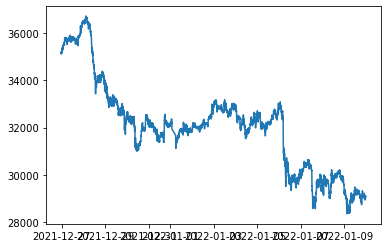

In [21]:
plt.plot(data.index, data['close'])

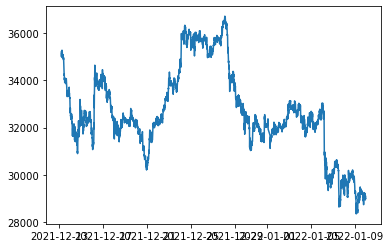

In [22]:
plt.plot(data2.index, data2['close'])

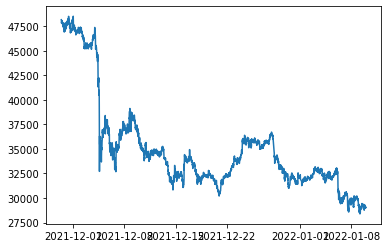

In [23]:
plt.plot(data3.index, data3['close'])

In [ ]:
plt.plot(data4.index, data4['close'])

In [13]:
from sklearn.preprocessing import MinMaxScaler

def minmaxscaler(data):
    scaler = MinMaxScaler()
    scale_cols = ['open','line_5','line_10','band_mid','band_up','band_low','UD']
    df_scaled = scaler.fit_transform(data[scale_cols])

    scaler_l = MinMaxScaler()
    scale_cols_l = ['close']
    df_scaled_l = scaler_l.fit_transform(data[scale_cols_l])

    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = scale_cols

    df_scaled_l = pd.DataFrame(df_scaled_l)
    df_scaled_l.columns = scale_cols_l
    print(df_scaled)
    print(df_scaled_l)
    return df_scaled, df_scaled_l, scaler, scaler_l

In [25]:
df_scaled, df_scaled_l, scaler, scaler_l = minmaxscaler(data)

          open    line_5   line_10  band_mid   band_up  band_low   UD
0     0.808153  0.806937  0.809768  0.816985  0.820547  0.809954  0.0
1     0.818945  0.809362  0.810867  0.816985  0.820547  0.809954  1.0
2     0.814149  0.810817  0.811355  0.816740  0.820175  0.809838  0.0
3     0.815348  0.813485  0.812210  0.816250  0.818964  0.810062  1.0
4     0.810552  0.814698  0.810989  0.815148  0.815521  0.811261  0.0
...        ...       ...       ...       ...       ...       ...  ...
3975  0.082734  0.070580  0.064469  0.069985  0.073090  0.082122  1.0
3976  0.074341  0.070580  0.064347  0.068699  0.070464  0.082171  0.0
3977  0.076739  0.071065  0.063858  0.067720  0.068265  0.082401  1.0
3978  0.082734  0.072035  0.064103  0.067352  0.067353  0.082572  1.0
3979  0.088729  0.073975  0.065690  0.067536  0.067844  0.082452  1.0

[3980 rows x 7 columns]
         close
0     0.819378
1     0.808612
2     0.816986
3     0.812201
4     0.818182
...        ...
3975  0.075359
3976  0.080144


In [26]:
df_scaled2, df_scaled_l2, scaler2, scaler_l2 = minmaxscaler(data2)

          open    line_5   line_10  band_mid   band_up  band_low   UD
0     0.809353  0.809687  0.796608  0.776528  0.811240  0.740961  0.0
1     0.818945  0.812378  0.801524  0.781027  0.817117  0.744003  1.0
2     0.809353  0.813112  0.804965  0.784964  0.820104  0.748770  0.0
3     0.796163  0.809687  0.806931  0.788339  0.820021  0.755437  0.0
4     0.806954  0.808953  0.809389  0.792401  0.819841  0.763541  1.0
...        ...       ...       ...       ...       ...       ...  ...
3975  0.068345  0.066047  0.070542  0.067992  0.060296  0.091531  0.0
3976  0.074341  0.060665  0.068084  0.067492  0.060754  0.090108  1.0
3977  0.079137  0.061644  0.066855  0.067554  0.060694  0.090288  1.0
3978  0.074341  0.061399  0.064274  0.065992  0.058765  0.089124  0.0
3979  0.082734  0.061888  0.063537  0.064867  0.056127  0.089505  1.0

[3980 rows x 7 columns]
         close
0     0.819378
1     0.812201
2     0.795455
3     0.808612
4     0.812201
...        ...
3975  0.081340
3976  0.081340


In [27]:
df_scaled3, df_scaled_l3, scaler3, scaler_l3 = minmaxscaler(data3)

          open    line_5   line_10  band_mid   band_up  band_low   UD
0     0.981123  0.982835  0.982880  0.966467  0.982162  0.932557  0.0
1     0.976652  0.987177  0.985014  0.969426  0.985105  0.935444  0.0
2     0.980129  0.989802  0.986335  0.972926  0.987122  0.940322  1.0
3     0.972181  0.988187  0.986538  0.975268  0.988533  0.943525  0.0
4     0.975658  0.987783  0.987757  0.977687  0.990068  0.946756  1.0
...        ...       ...       ...       ...       ...       ...  ...
3975  0.033780  0.030897  0.030734  0.020408  0.014834  0.036125  1.0
3976  0.028316  0.028574  0.029464  0.020202  0.014817  0.035737  0.0
3977  0.032290  0.027565  0.028905  0.020279  0.014853  0.035853  1.0
3978  0.030800  0.026454  0.028042  0.020537  0.014712  0.036500  0.0
3979  0.036761  0.027666  0.027991  0.021000  0.014955  0.037171  1.0

[3980 rows x 7 columns]
         close
0     0.982613
1     0.980129
2     0.972181
3     0.965226
4     0.968207
...        ...
3975  0.027819
3976  0.032290


In [255]:
df_scaled4, df_scaled_l4, scaler4, scaler_l4 = minmaxscaler(data4)

          open    line_5   line_10  band_mid   band_up  band_low   UD
0     0.680839  0.692782  0.698797  0.700057  0.666342  0.707408  0.0
1     0.676871  0.691226  0.696744  0.699078  0.666574  0.705219  0.0
2     0.673186  0.689498  0.694777  0.698085  0.667433  0.702347  0.0
3     0.681122  0.688288  0.693273  0.697676  0.667404  0.701564  1.0
4     0.695295  0.690132  0.693273  0.698188  0.668158  0.701796  1.0
...        ...       ...       ...       ...       ...       ...  ...
3975  0.020692  0.015611  0.011076  0.008821  0.003300  0.022177  1.0
3976  0.018707  0.017109  0.010961  0.008441  0.002428  0.022330  0.0
3977  0.015023  0.016936  0.010845  0.007959  0.001818  0.022005  0.0
3978  0.013605  0.015496  0.010614  0.007623  0.001783  0.021373  0.0
3979  0.015023  0.014517  0.010903  0.007185  0.001159  0.021151  1.0

[3980 rows x 7 columns]
         close
0     0.676396
1     0.672712
2     0.680646
3     0.692831
4     0.688864
...        ...
3975  0.018135
3976  0.014452


In [14]:
def make_dataset(data, label, window_size=30):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [15]:
from sklearn.model_selection import train_test_split

def feature(df_scaled, df_scaled_l, size=30):
    TEST_SIZE=200
    xtrain = df_scaled[:-TEST_SIZE]
    ytrain = df_scaled_l[:-TEST_SIZE]
    xtest = df_scaled[-TEST_SIZE:]
    ytest = df_scaled_l[-TEST_SIZE:]
    train_feature, train_label = make_dataset(xtrain, ytrain, size)
    x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
    test_feature, test_label = make_dataset(xtest, ytest, size)
    return x_train, x_valid, y_train, y_valid, test_feature, test_label, train_feature.shape[1], train_feature.shape[2]

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

def model_lstm(x_train, x_valid, y_train, y_valid, test_feature, test_label, shape1, shape2):
    model = Sequential()
    model.add(LSTM(16,
                   input_shape=(shape1, shape2), 
                   activation='elu', 
                   return_sequences=False)
              )
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    history = model.fit(x_train, y_train, 
                        epochs=100, 
                        batch_size=15,
                        verbose=0,
                        validation_data=(x_valid, y_valid), 
                        callbacks=[early_stop])
    return model

In [17]:
def model_predict(model, test_feature, test_label, scaler_l):
    pred = model.predict(test_feature)
    pred_price=scaler_l.inverse_transform(pred)
    test_price=scaler_l.inverse_transform(test_label)
    return pred_price, test_price

In [18]:
def mean_test(test_price,pred_price):
    mean_list=[]
    for i in range(len(test_price)):
        diff=abs(test_price[i]-pred_price[i])+test_price[i]
        mean_list.append(diff)
    mean_diff=abs(np.mean(mean_list)-np.mean(test_price))
    return np.round(mean_diff/np.mean(test_price)*1000,2)

In [19]:
def optimize_size(df_scaled, df_scaled_l, scaler_l):
    min_dic={}
    for k in tqdm(range(10,50)):
        x_train, x_valid, y_train, y_valid, test_feature, test_label, shape1, shape2 = feature(df_scaled, df_scaled_l, k)
        model = model_lstm(x_train, x_valid, y_train, y_valid, test_feature, test_label, shape1, shape2)
        pred_price, test_price = model_predict(model, test_feature, test_label, scaler_l)
        min_dic[k]=mean_test(test_price,pred_price)
        
    sort_dic=sorted(min_dic.items(), key=(lambda x:x[1]))
    print("Optimize key : ", sort_dic[0][0], ", Optimize rate : ", sort_dic[0][1])
    x_train, x_valid, y_train, y_valid, test_feature, test_label, shape1, shape2 = feature(df_scaled, df_scaled_l, sort_dic[0][0])
    model = model_lstm(x_train, x_valid, y_train, y_valid, test_feature, test_label, shape1, shape2)
    pred_price, test_price = model_predict(model, test_feature, test_label, scaler_l)
    
    return test_feature, model, pred_price, test_price, sort_dic[0][0], sort_dic

In [35]:
test_feature, model, pred_price, test_price, size_key, size_dic = optimize_size(df_scaled, df_scaled_l, scaler_l)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [16:34<00:00, 24.87s/it]


Optimize key :  32 , Optimize rate :  2.24


In [36]:
lst=[test_feature, model, pred_price, test_price, size_key, size_dic, scaler, scaler_l]
name=['test_feature', 'model', 'pred_price', 'test_price', 'size_key', 'size_dic', 'scaler', 'scaler_l']
for i in range(len(lst)):
    if i!=1:
        with open('./coin_data/'+name[i]+'.pickle','wb') as fw:
            pickle.dump(lst[i], fw)
    else:
        lst[i].save('./coin_data/'+name[i]+'.h5')

In [37]:
test_feature2, model2, pred_price2, test_price2, size_key2, size_dic2 = optimize_size(df_scaled2, df_scaled_l2, scaler_l2)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [17:38<00:00, 26.45s/it]


Optimize key :  12 , Optimize rate :  3.44


In [38]:
lst=[test_feature2, model2, pred_price2, test_price2, size_key2, size_dic2, scaler2, scaler_l2]
name=['test_feature2', 'model2', 'pred_price2', 'test_price2', 'size_key2', 'size_dic2', 'scaler2', 'scaler_l2']
for i in range(len(lst)):
    if i!=1:
        with open('./coin_data/'+name[i]+'.pickle','wb') as fw:
            pickle.dump(lst[i], fw)
    else:
        lst[i].save('./coin_data/'+name[i]+'.h5')

In [39]:
test_feature3, model3, pred_price3, test_price3, size_key3, size_dic3 = optimize_size(df_scaled3, df_scaled_l3, scaler_l3)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [16:08<00:00, 24.20s/it]


Optimize key :  49 , Optimize rate :  4.04


In [40]:
lst=[test_feature3, model3, pred_price3, test_price3, size_key3, size_dic3, scaler3, scaler_l3]
name=['test_feature3', 'model3', 'pred_price3', 'test_price3', 'size_key3', 'size_dic3', 'scaler3', 'scaler_l3']
for i in range(len(lst)):
    if i!=1:
        with open('./coin_data/'+name[i]+'.pickle','wb') as fw:
            pickle.dump(lst[i], fw)
    else:
        lst[i].save('./coin_data/'+name[i]+'.h5')

In [256]:
test_feature4, model4, pred_price4, test_price4, size_key4, size_dic4 = optimize_size(df_scaled4, df_scaled_l4, scaler_l4)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [14:53<00:00, 22.33s/it]


Optimize key :  38 , Optimize rate :  6.83


In [257]:
lst=[test_feature4, model4, pred_price4, test_price4, size_key4, size_dic4, scaler4, scaler_l4]
name=['test_feature4', 'model4', 'pred_price4', 'test_price4', 'size_key4', 'size_dic4', 'scaler4', 'scaler_l4']
for i in range(len(lst)):
    if i!=1:
        with open('./coin_data/'+name[i]+'.pickle','wb') as fw:
            pickle.dump(lst[i], fw)
    else:
        lst[i].save('./coin_data/'+name[i]+'.h5')

In [21]:
from keras.models import load_model
#valid_data, start_settings, tickers_list[6], scaler, scaler_l, model, test_feature, col[0], size_key+20, 1
name=['test_feature', 'model', 'pred_price', 'test_price', 'size_key', 'size_dic', 'scaler', 'scaler_l']
with open('./coin_data/'+name[0]+'.pickle', 'rb') as f: 
    test_feature = pickle.load(f)
with open('./coin_data/'+name[2]+'.pickle', 'rb') as f: 
    pred_price = pickle.load(f)
with open('./coin_data/'+name[3]+'.pickle', 'rb') as f: 
    test_price = pickle.load(f)
with open('./coin_data/'+name[4]+'.pickle', 'rb') as f: 
    size_key = pickle.load(f)
with open('./coin_data/'+name[5]+'.pickle', 'rb') as f: 
    size_dic = pickle.load(f)
with open('./coin_data/'+name[6]+'.pickle', 'rb') as f: 
    scaler = pickle.load(f)
with open('./coin_data/'+name[7]+'.pickle', 'rb') as f: 
    scaler_l = pickle.load(f)

model=load_model('./coin_data/'+name[1]+'.h5')

In [22]:
name=['test_feature2', 'model2', 'pred_price2', 'test_price2', 'size_key2', 'size_dic2', 'scaler2', 'scaler_l2']
with open('./coin_data/'+name[0]+'.pickle', 'rb') as f: 
    test_feature2 = pickle.load(f)
with open('./coin_data/'+name[2]+'.pickle', 'rb') as f: 
    pred_price2 = pickle.load(f)
with open('./coin_data/'+name[3]+'.pickle', 'rb') as f: 
    test_price2 = pickle.load(f)
with open('./coin_data/'+name[4]+'.pickle', 'rb') as f: 
    size_key2 = pickle.load(f)
with open('./coin_data/'+name[5]+'.pickle', 'rb') as f: 
    size_dic2 = pickle.load(f)
with open('./coin_data/'+name[6]+'.pickle', 'rb') as f: 
    scaler2 = pickle.load(f)
with open('./coin_data/'+name[7]+'.pickle', 'rb') as f: 
    scaler_l2 = pickle.load(f)


model2=load_model('./coin_data/'+name[1]+'.h5')

In [23]:
name=['test_feature3', 'model3', 'pred_price3', 'test_price3', 'size_key3', 'size_dic3', 'scaler3', 'scaler_l3']
with open('./coin_data/'+name[0]+'.pickle', 'rb') as f: 
    test_feature3 = pickle.load(f)
with open('./coin_data/'+name[2]+'.pickle', 'rb') as f: 
    pred_price3 = pickle.load(f)
with open('./coin_data/'+name[3]+'.pickle', 'rb') as f: 
    test_price3 = pickle.load(f)
with open('./coin_data/'+name[4]+'.pickle', 'rb') as f: 
    size_key3 = pickle.load(f)
with open('./coin_data/'+name[5]+'.pickle', 'rb') as f: 
    size_dic3 = pickle.load(f)
with open('./coin_data/'+name[6]+'.pickle', 'rb') as f: 
    scaler3 = pickle.load(f)
with open('./coin_data/'+name[7]+'.pickle', 'rb') as f: 
    scaler_l3 = pickle.load(f)

model3=load_model('./coin_data/'+name[1]+'.h5')

In [24]:
name=['test_feature4', 'model4', 'pred_price4', 'test_price4', 'size_key4', 'size_dic4', 'scaler4', 'scaler_l4']
with open('./coin_data/'+name[0]+'.pickle', 'rb') as f: 
    test_feature4 = pickle.load(f)
with open('./coin_data/'+name[2]+'.pickle', 'rb') as f: 
    pred_price4 = pickle.load(f)
with open('./coin_data/'+name[3]+'.pickle', 'rb') as f: 
    test_price4 = pickle.load(f)
with open('./coin_data/'+name[4]+'.pickle', 'rb') as f: 
    size_key4 = pickle.load(f)
with open('./coin_data/'+name[5]+'.pickle', 'rb') as f: 
    size_dic4 = pickle.load(f)
with open('./coin_data/'+name[6]+'.pickle', 'rb') as f: 
    scaler4 = pickle.load(f)
with open('./coin_data/'+name[7]+'.pickle', 'rb') as f: 
    scaler_l4 = pickle.load(f)

model4=load_model('./coin_data/'+name[1]+'.h5')

In [44]:
np.roll(test_price,1)

array([[29090.],
       [29170.],
       [29160.],
       [29130.],
       [29160.],
       [29060.],
       [29070.],
       [29020.],
       [28920.],
       [28960.],
       [29100.],
       [28990.],
       [29060.],
       [29010.],
       [29140.],
       [29170.],
       [29180.],
       [29260.],
       [29320.],
       [29350.],
       [29350.],
       [29310.],
       [29290.],
       [29390.],
       [29490.],
       [29400.],
       [29440.],
       [29330.],
       [29310.],
       [29290.],
       [29300.],
       [29330.],
       [29330.],
       [29250.],
       [29210.],
       [29180.],
       [29180.],
       [29140.],
       [29180.],
       [29180.],
       [29230.],
       [29270.],
       [29240.],
       [29250.],
       [29300.],
       [29320.],
       [29310.],
       [29330.],
       [29320.],
       [29340.],
       [29400.],
       [29390.],
       [29390.],
       [29340.],
       [29260.],
       [29200.],
       [29270.],
       [29210.],
       [29300.

In [45]:
test_price[20]

array([29310.])

In [46]:
pred_price[21]

array([29325.922], dtype=float32)

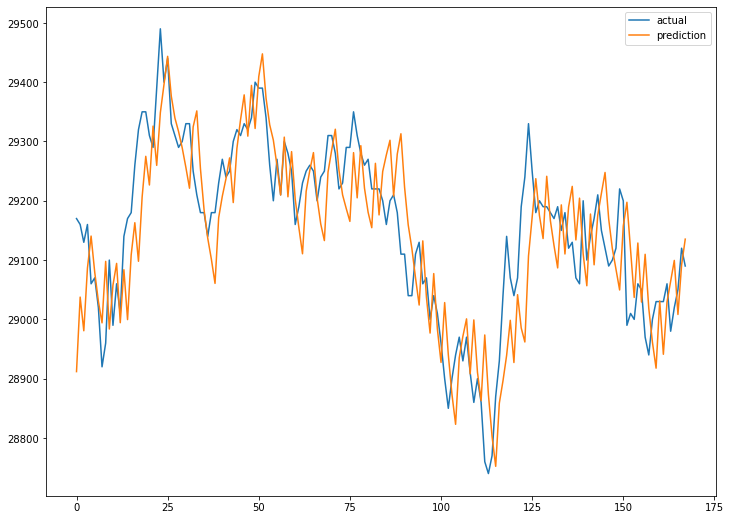

In [47]:
plt.figure(figsize=(12, 9))
plt.plot(test_price, label='actual')
plt.plot(pred_price, label='prediction')
plt.legend()
plt.show()

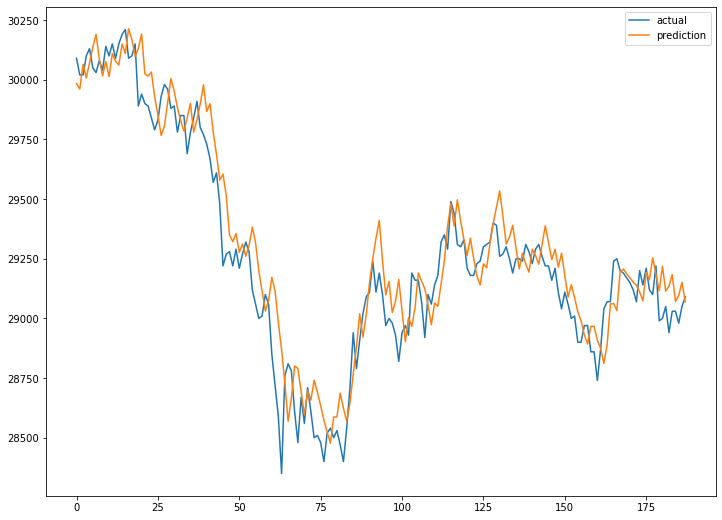

In [48]:
plt.figure(figsize=(12, 9))
plt.plot(test_price2, label='actual')
plt.plot(pred_price2, label='prediction')
plt.legend()
plt.show()

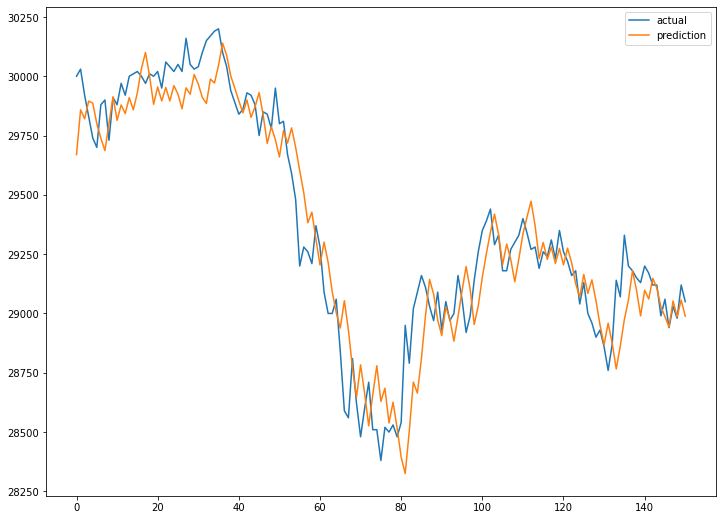

In [49]:
plt.figure(figsize=(12, 9))
plt.plot(test_price3, label='actual')
plt.plot(pred_price3, label='prediction')
plt.legend()
plt.show()

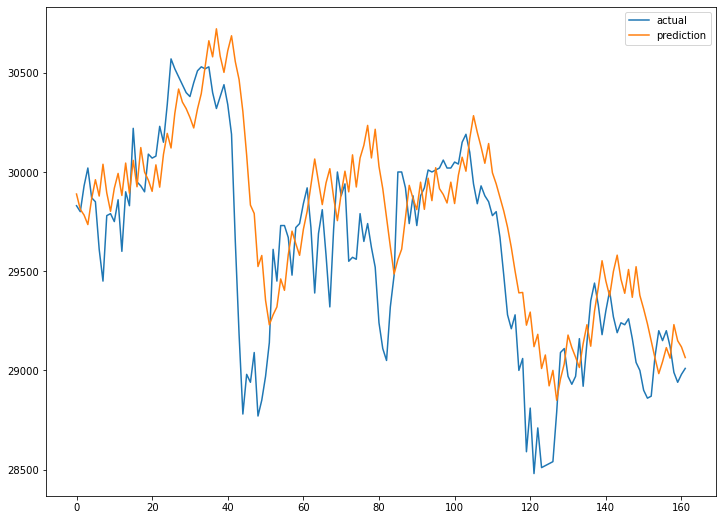

In [259]:
plt.figure(figsize=(12, 9))
plt.plot(test_price4, label='actual')
plt.plot(pred_price4, label='prediction')
plt.legend()
plt.show()

In [50]:
# dataframe 만들기

In [25]:
valid_data=data[-(200-size_key):][['open','close']]

In [26]:
col=['pred_5','pred_10','pred_15','pred_30']
for c in col:
    valid_data[c]=np.nan

In [27]:
valid_data.head()

,open,close,pred_5,pred_10,pred_15,pred_30
2022-01-10 02:15:00,29380.0,29480.0,NaN,NaN,NaN,NaN
2022-01-10 02:20:00,29470.0,29480.0,NaN,NaN,NaN,NaN
2022-01-10 02:25:00,29470.0,29470.0,NaN,NaN,NaN,NaN
2022-01-10 02:30:00,29460.0,29490.0,NaN,NaN,NaN,NaN
2022-01-10 02:35:00,29420.0,29380.0,NaN,NaN,NaN,NaN


In [28]:
def minmaxscaler_transform(data, scaler, scaler_l):
    scale_cols = ['open','line_5','line_10','band_mid','band_up','band_low','UD']
    df_scaled = scaler.transform(data[scale_cols])

    scale_cols_l = ['close']
    df_scaled_l = scaler_l.transform(data[scale_cols_l])

    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = scale_cols

    df_scaled_l = pd.DataFrame(df_scaled_l)
    df_scaled_l.columns = scale_cols_l
    
    return df_scaled, df_scaled_l

In [29]:
def model_predict_one(model, test_feature, result_train_x, scaler_l):
    pred = model.predict(result_train_x.values.reshape(1,test_feature[0].shape[0],test_feature[0].shape[1]))
    pred_price=scaler_l.inverse_transform(pred)
    return pred_price

In [30]:
def result_df(valid_data, start_s, tickers, scaler, scaler_l, model, test_feature, col='pred_5', cnt=45, num=1):
    for idex in valid_data.index:
        result_data=settings_data(start_s, tickers, idex, cnt, num)
        result_train_x, _ =minmaxscaler_transform(result_data, scaler, scaler_l)
        valid_data.loc[idex,col]=model_predict_one(model, test_feature, result_train_x, scaler_l)[0][0]
        time.sleep(0.1)
    return valid_data

In [31]:
valid_data=result_df(valid_data, start_settings, tickers_list[2], scaler, scaler_l, model, test_feature, col[0], size_key+20, 1)

In [32]:
valid_data=result_df(valid_data, start_settings2,tickers_list[2], scaler2, scaler_l2, model2, test_feature2, col[1], size_key2+20, 1)

In [33]:
valid_data=result_df(valid_data, start_settings3, tickers_list[2], scaler3, scaler_l3, model3, test_feature3, col[2], size_key3+20, 1)

In [34]:
valid_data=result_df(valid_data, start_settings4, tickers_list[2], scaler4, scaler_l4, model4, test_feature4, col[3], size_key4+20, 1)

In [231]:
valid_data.to_csv("coin_test.csv")

In [34]:
valid_data=pd.read_csv("coin_test.csv")

In [35]:
valid_data.set_index('Unnamed: 0', inplace=True)

In [166]:
# 수익률 예측 테스트 # backtracking
valid_data['check']=''
balance=700000
fee=0.0005
buy=False
start_price=[]
avg_price=0
comulative_rate=[]
cnt=20
watch=1
for i in range(len(valid_data.index)):
    idex=valid_data.index[i]
    
    # 변수 할당
    temp=valid_data[['pred_5','pred_10','pred_15','pred_30']]
    temp=temp.iloc[i]
    rank_col1=sorted(temp.rank().items(), key=lambda x:x[1])[0][0]
    rank_col2=sorted(temp.rank().items(), key=lambda x:x[1])[1][0]
    rank_col3=sorted(temp.rank().items(), key=lambda x:x[1])[2][0]
    rank_col4=sorted(temp.rank().items(), key=lambda x:x[1])[3][0]
    rank_pf=valid_data.loc[idex,rank_col1]
    rank_ps=valid_data.loc[idex,rank_col2]
    rank_pt=valid_data.loc[idex,rank_col3]
    rank_pff=valid_data.loc[idex,rank_col4]
    valid_p5=valid_data.loc[idex,'pred_5']
    valid_p10=valid_data.loc[idex,'pred_10']
    valid_p15=valid_data.loc[idex,'pred_15']
    valid_p30=valid_data.loc[idex,'pred_30']
    
    # buy 구간rank_pf,rank_ps,rank_pt
    if valid_data.loc[idex,'open']<=rank_pff and valid_data.loc[idex,'open']<=rank_pt:
        if buy==False:
            start_price.append(valid_data.loc[idex,'open']*cnt)
            avg_price=sum(start_price)/len(start_price*cnt)
            balance-=np.round(valid_data.loc[idex,'open']*cnt*(1+fee),1)
            print("매수 후 balance:", balance)
            buy=True
            valid_data.loc[idex,'check']='매수'
        # 추가 buy 구간
#         elif buy and avg_price>valid_data.loc[idex,'open']:
#             start_price.append(valid_data.loc[idex,'open']*cnt)
#             avg_price=sum(start_price)/len(start_price*cnt)
#             balance-=np.round(valid_data.loc[idex,'open']*cnt*(1+fee),1)
#             print("매수 후 balance:", balance)
#             valid_data.loc[idex,'check']='추가매수'
        
    else:
        # sell 구간
        if valid_data.loc[idex,'open']>max(valid_p5,valid_p10,valid_p15,valid_p30) and buy:
            rate=(valid_data.loc[idex,'close']-avg_price)/avg_price
            balance+=np.round((valid_data.loc[idex,'close']*cnt*len(start_price))*(1-fee),1)
            buy=False
            max_count=len(start_price)
            start_price=[]
            comulative_rate.append(rate)
            valid_data.loc[idex,'check']='매도:'+str(np.round(rate*100,3))+'%'
            print("buy:",np.round(avg_price,1), "sell:",valid_data.loc[idex,'close'], ">>> 남은 잔액:",np.round(balance,1), "수익률:", np.round(rate*100,3),"%", "max_count:",max_count)
    if i%12==0:
        print(watch,"시간 경과 >>> 남은 잔액:",sum(start_price)+np.round(balance,1))
        watch+=1
print("최종 >>> 남은 잔액:",sum(start_price)+np.round(balance,1), "누적수익률:", np.round(np.mean(comulative_rate)*100,3),"%")

매수 후 balance: 112106.19999999995
1 시간 경과 >>> 남은 잔액: 699706.2
buy: 29380.0 sell: 29480.0 >>> 남은 잔액: 701411.4 수익률: 0.34 % max_count: 1
매수 후 balance: 111716.69999999995
buy: 29470.0 sell: 29340.0 >>> 남은 잔액: 698223.3 수익률: -0.441 % max_count: 1
매수 후 balance: 109128.8999999999
2 시간 경과 >>> 남은 잔액: 697928.9
buy: 29440.0 sell: 29480.0 >>> 남은 잔액: 698434.1 수익률: 0.136 % max_count: 1
매수 후 balance: 109539.79999999981
3 시간 경과 >>> 남은 잔액: 698139.8
buy: 29430.0 sell: 29430.0 >>> 남은 잔액: 697845.5 수익률: 0.0 % max_count: 1
매수 후 balance: 107550.49999999977
buy: 29500.0 sell: 29520.0 >>> 남은 잔액: 697655.3 수익률: 0.068 % max_count: 1
매수 후 balance: 106960.09999999986
buy: 29520.0 sell: 29560.0 >>> 남은 잔액: 697864.5 수익률: 0.136 % max_count: 1
매수 후 balance: 106368.8999999999
4 시간 경과 >>> 남은 잔액: 697568.9
buy: 29560.0 sell: 29490.0 >>> 남은 잔액: 695874.0 수익률: -0.237 % max_count: 1
매수 후 balance: 104978.69999999984
buy: 29530.0 sell: 29580.0 >>> 남은 잔액: 696282.9 수익률: 0.169 % max_count: 1
5 시간 경과 >>> 남은 잔액: 696282.9
매수 후 balance: 1

In [167]:
valid_data[:50]

,open,close,pred_5,pred_10,pred_15,pred_30,check,pred_5UB,pred_10UB,pred_15UB,pred_30UB
2022-01-10 02:15:00,29380.0,29480.0,29382.693359,29407.902344,29224.064453,29329.878906,매수,True,True,True,True
2022-01-10 02:20:00,29470.0,29480.0,29354.328125,29407.902344,29184.878906,29329.878906,매도:0.34%,False,False,False,False
2022-01-10 02:25:00,29470.0,29470.0,29470.531250,29519.791016,29184.878906,29329.878906,매수,False,False,True,True
2022-01-10 02:30:00,29460.0,29490.0,29409.130859,29519.791016,29184.878906,29329.878906,,True,False,True,True
2022-01-10 02:35:00,29420.0,29380.0,29375.585938,29451.681641,29277.101562,29296.970703,,False,False,True,True
2022-01-10 02:40:00,29340.0,29390.0,29343.894531,29451.681641,29277.101562,29296.970703,,True,False,True,True
2022-01-10 02:45:00,29390.0,29340.0,29301.070312,29360.169922,29277.101562,29296.970703,매도:-0.441%,False,False,False,False
2022-01-10 02:50:00,29370.0,29390.0,29401.248047,29360.169922,29265.767578,29296.970703,,False,True,True,True
2022-01-10 02:55:00,29390.0,29510.0,29317.474609,29422.218750,29265.767578,29296.970703,,True,True,True,True
2022-01-10 03:00:00,29510.0,29440.0,29386.820312,29422.218750,29265.767578,29296.970703,,False,False,False,False


In [118]:
# 예측 정확도 테스트
valid_data['pred_5UB']=False
valid_data['pred_10UB']=False
valid_data['pred_15UB']=False
valid_data['pred_30UB']=False
for i in range(len(valid_data.index)-1):
    idex=valid_data.index[i]
    fidex=valid_data.index[i+1]
    if valid_data.loc[idex,'open']>max(valid_data.loc[idex,'pred_5'],valid_data.loc[idex,'pred_10'],valid_data.loc[idex,'pred_15'],
                                      valid_data.loc[idex,'pred_30']):
#         if valid_data.loc[fidex,'open']<valid_data.loc[idex,'open']:
#             valid_data.loc[idex,'pred_5UB']=True
#         else:
        continue
    if valid_data.loc[idex,'open']<=max(valid_data.loc[idex,'pred_5'],valid_data.loc[idex,'pred_10'],valid_data.loc[idex,'pred_15'],
                                      valid_data.loc[idex,'pred_30']):
        if valid_data.loc[idex,'pred_5']<=valid_data.loc[fidex,'open']:
            valid_data.loc[idex,'pred_5UB']=True
        if valid_data.loc[idex,'pred_10']<=valid_data.loc[fidex,'open']:
            valid_data.loc[idex,'pred_10UB']=True
        if valid_data.loc[idex,'pred_15']<=valid_data.loc[fidex,'open']:
            valid_data.loc[idex,'pred_15UB']=True
        if valid_data.loc[idex,'pred_30']<=valid_data.loc[fidex,'open']:
            valid_data.loc[idex,'pred_30UB']=True

In [119]:
valid_data.head(20)

,open,close,pred_5,pred_10,pred_15,pred_30,check,pred_5UB,pred_10UB,pred_15UB,pred_30UB
2022-01-10 02:15:00,29380.0,29480.0,29382.693359,29407.902344,29224.064453,29329.878906,매수,True,True,True,True
2022-01-10 02:20:00,29470.0,29480.0,29354.328125,29407.902344,29184.878906,29329.878906,매도:0.306%,False,False,False,False
2022-01-10 02:25:00,29470.0,29470.0,29470.531250,29519.791016,29184.878906,29329.878906,매수,False,False,True,True
2022-01-10 02:30:00,29460.0,29490.0,29409.130859,29519.791016,29184.878906,29329.878906,,True,False,True,True
2022-01-10 02:35:00,29420.0,29380.0,29375.585938,29451.681641,29277.101562,29296.970703,,False,False,True,True
2022-01-10 02:40:00,29340.0,29390.0,29343.894531,29451.681641,29277.101562,29296.970703,,True,False,True,True
2022-01-10 02:45:00,29390.0,29340.0,29301.070312,29360.169922,29277.101562,29296.970703,매도:-0.271%,False,False,False,False
2022-01-10 02:50:00,29370.0,29390.0,29401.248047,29360.169922,29265.767578,29296.970703,,False,True,True,True
2022-01-10 02:55:00,29390.0,29510.0,29317.474609,29422.218750,29265.767578,29296.970703,,True,True,True,True
2022-01-10 03:00:00,29510.0,29440.0,29386.820312,29422.218750,29265.767578,29296.970703,,False,False,False,False


In [120]:
sum((valid_data['pred_5UB']==True))/(len(valid_data)-1)

0.592814371257485

In [121]:
sum((valid_data['pred_10UB']==True))/(len(valid_data)-2)

0.3433734939759036

In [122]:
sum((valid_data['pred_15UB']==True))/(len(valid_data)-3)

0.5696969696969697

In [123]:
sum((valid_data['pred_30UB']==True))/(len(valid_data)-6)

0.22839506172839505

In [124]:
cntt=0
for idex in valid_data.index:
    if valid_data.loc[idex,'pred_5UB'] or valid_data.loc[idex,'pred_10UB'] or valid_data.loc[idex,'pred_15UB'] or valid_data.loc[idex,'pred_30UB']:
        cntt+=1

In [125]:
cntt/(len(valid_data)-6)

0.7839506172839507

In [70]:
temp=valid_data[['pred_5','pred_10','pred_15','pred_30']]
temp=temp.iloc[0]


pred_5     3.0
pred_10    4.0
pred_15    1.0
pred_30    2.0
Name: 2022-01-10 02:15:00, dtype: float64

In [79]:
sorted(temp.rank().items(), key=lambda x:x[1])[0][0]

'pred_15'

In [75]:
temp.rank().items()

In [54]:
# 트위터 활용하기
import tweepy

In [55]:
# 트위터 api key
API_Key='80RNVNLQWrwPOcolCZd1bRUEh'
secret_Key='6E4IdJLXUifXdrpwOkAjtG5pdKFmB7EP1ALnAdDTsfPPfeV24V'
bearer_Token='AAAAAAAAAAAAAAAAAAAAABH9XgEAAAAAajipuF2UJm%2BYMhF1GsIAMkwUqso%3D2aALA5qjG7sTYW0WzVJqetrzZNH9cU3qB7WhVIN0BqtTk2N1YJ'
access_token_key='1478324496855875584-oWOWjfqmDZ0vel1580ucvtjPBvjhGQ'
access_token_secret='m5bwyHzwoU76IgiaM8KeRYI6enB9WFxcPVQxACdXsApsK'

In [56]:
auth=tweepy.OAuthHandler(API_Key, secret_Key)
auth.set_access_token(access_token_key, access_token_secret)
twitter_api = tweepy.API(auth)

In [57]:
# 날짜 이후로 keyword 검색하기
valid_data.index[0]

Timestamp('2022-01-07 08:15:00')

In [58]:
valid_data.index[-1]

Timestamp('2022-01-08 00:00:00')

In [59]:
korea_geo = "%s,%s,%s" % ("35.95", "128.25", "1000km")
keyword = "etc"
cursor=tweepy.Cursor(twitter_api.search, q=keyword, geocode=korea_geo).items(10)

In [134]:
for tweet in cursor:
    print(tweet.created_at)
    print("text:",tweet.text)
    time.sleep(0.1)

2022-01-07 08:19:13
text: @foxy_moonflower Pour l’heure, j’avais vu à Tokyo une japonaise qui avait invitée un ami (ou petit ami) chez elle,… https://t.co/pFE9aUlS0F
2022-01-07 08:19:02
text: 요즘 이 집안 식구들 쭉봐봐.
나야 늘봐 다 알기고

전부다 망하고 망가지고 어데하나 성한데가 있는지.

마치 예전의 국가권력의 공작,농간에 한집안이 풍비박산 나 
다 죽고 망하고 불행에빠진

"수지 김"사… https://t.co/HqxqrnBIMe
2022-01-07 08:18:26
text: Lover, and Giuk's character misses his mom bc she's far away, etc etc; which makes all of them a memory that they m… https://t.co/fAcNXgoZ0i
2022-01-07 08:17:27
text: If you've ever wanted to see a pro futsal game, next week's F.League match between YSCC &amp; Tachikawa/Fuchu Athletic… https://t.co/Ri9V6boqNv
2022-01-07 08:15:11
text: 🚄 #ETH and 28 Others,  🟢 29

🇰🇷 44.78억원
🇺🇸 $3,832,050
🇯🇵 ¥420,906,125
🇪🇺 €3,243,367
🇨🇳 24,738,668元

🎉Upflow volume… https://t.co/xxr1QhWeTr
2022-01-07 08:14:20
text: @maciekczalej @ni_ebede Prawda, ale skoro nie wiedział, czy można nazwać go pedofilem? Do tego skoro ta dziewczyna… https://t.co/nLtDB4Vaa

In [202]:
valid_data[70:90]

,open,close,pred_5,pred_10,pred_15,p_5,p_10,p_15,UB
Unnamed: 0,,,,,,,,,
2022-01-05 16:05:00,42160.0,42180.0,42178.289062,42096.183594,42140.714844,True,False,False,True
2022-01-05 16:10:00,42190.0,42230.0,42199.875000,42096.183594,42140.714844,True,False,False,True
2022-01-05 16:15:00,42220.0,42210.0,42233.636719,42139.476562,42140.714844,True,False,False,True
2022-01-05 16:20:00,42190.0,42230.0,42227.167969,42139.476562,42190.507812,True,False,True,False
2022-01-05 16:25:00,42230.0,42190.0,42247.699219,42166.269531,42190.507812,True,False,False,True
2022-01-05 16:30:00,42190.0,42150.0,42223.375000,42166.269531,42190.507812,True,False,True,False
2022-01-05 16:35:00,42140.0,42120.0,42170.605469,42157.230469,42165.585938,True,True,True,False
2022-01-05 16:40:00,42120.0,42120.0,42146.445312,42157.230469,42165.585938,True,True,True,False
2022-01-05 16:45:00,42120.0,42100.0,42137.148438,42124.238281,42165.585938,True,True,True,False
